In [ ]:
!pip install shap

In [ ]:
!pip install scikit-bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 50.6 MB/s eta 0:00:00


In [ ]:
!pip install mimic-da

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 33.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.2/282.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.9 MB/s eta 0:00:00
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273786 sha256=656658fe5eac2cbbd88c5d032e7a9847fe415f73a39951310f7b1aca8787ea97
  Stored in directory: /root/.cache/pip/wheels/4f/18/8d/3800b8b1dc7a8c1954eaa48424f639b2cfc760922cc3cee479
  Created wheel for sewar: filename=sewar-0.4.6-py3-none-any.whl size=11418 sha256=607b328e6d2a09c59e20bcb13

# **Imports**

In [ ]:
#data processing
import pandas as pd
import numpy as np
from pathlib import Path

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

#Machine learning library
import sklearn
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import spearmanr, mannwhitneyu

# Microbiome analysis
from skbio.stats.distance import permanova, DistanceMatrix
from skbio.diversity import alpha_diversity, beta_diversity
from skbio.stats.ordination import pcoa

import warnings
warnings.filterwarnings("ignore")

# **Read Data**

In [ ]:
class Config:
    """Configuration settings for the analysis"""

    # Base folder where input files are located and outputs will be saved
    BASE_FOLDER = "."  # Current directory by default

    # Output directory (relative to base_folder)
    @property
    def OUTPUT_DIR(self):
        return f"{self.BASE_FOLDER}/analysis_result"

    # File paths (relative to base_folder)
    METADATA_FULL = "metadata_OK195.csv"
    METADATA_TIME_A = "metadata_OK195__T[A].csv"
    SCFA_PATH = "SCFAs_ordered.csv"
    MIPMLP_B_C = "1-MIPMLP_B-C_T[A]_overlap.csv"
    METADATA_B_C = "1-metadata_B-C_T[A]_overlap.csv"
    MIPMLP_MEAN = "2-MIPMLP_mean_ordered.csv"
    METADATA_MIPMLP_MEAN = "2-metadata_ordered_correspond_to_MIPMLP_mean.csv"

    # Feature definitions
    SCFA_COLUMNS = [
        'Acetic acid', 'Propionic acid', 'I-Butytic acid',
        'Butyric acid', 'I-Valeric acid', 'Valeric acid'
    ]

    CLINICAL_COLUMNS = [
        'AGE', 'BMI',
        'Cort (awakening)', 'Cort (awakening+30)',
        'Cort (awakening response)', 'Cort (Night)',
        'FEV1/FVC (Z)', 'COppm'
    ]

    ACTIGRAPHY_COLUMNS = [
        'Acti_Start Time_D', 'Acti_End Time_D', 'Acti_Duration',
        'Acti_Onset Latency', 'Acti_Efficiency', 'Acti_WASO', 'Acti_%Sleep'
    ]

    PSG_COLUMNS = [
        'PSG_SleepEfficiency', 'PSG_SustainedSleep%', 'PSG_TST',
        'PSG_SOL', 'PSG_WASO', 'PSG_%Sleep', 'PSG_N1%', 'PSG_N2%',
        'PSG_N3%', 'PSG_REM%', 'PSG_Arousals'
    ]

    QUESTIONNAIRE_COLUMNS = [
        'ISI_Sum', 'NRS_Sum', 'PSQI_total_Sum',
        'PSAS_Somatic_Sum', 'PSAS_Cognitive_Sum',
        'Depression_Beck_Sum', 'Anxiety_STAI_State_Sum'
    ]

    # Analysis parameters
    TARGET_COLUMN = 'Tag'  # Group labels (A, B, C)
    RANDOM_STATE = 42
    ALPHA = 0.05  # Statistical significance threshold

    # Machine learning parameters
    SVM_KERNEL = 'rbf'
    SVM_GAMMA = 1
    SVM_PROBABILITY = True



In [ ]:
def load_all_data(min_nonzero=5):
    """
    Load all required datasets for the analysis and filter sparse microbes
    AFTER subsetting to Time == 'A' (to avoid false sparse retention).
    """

    print("Loading data files...")

    config = Config()
    base_path = Path(config.BASE_FOLDER)
    data = {}

    try:
        # --- Load all files ---
        data['metadata_full'] = pd.read_csv(base_path / Config.METADATA_FULL, index_col=0)
        print(f"✓ Loaded full metadata: {data['metadata_full'].shape}")

        data['metadata_A'] = pd.read_csv(base_path / Config.METADATA_TIME_A, index_col=0)
        print(f"✓ Loaded Time A metadata: {data['metadata_A'].shape}")

        data['scfa'] = pd.read_csv(base_path / Config.SCFA_PATH, index_col=0)
        print(f"✓ Loaded SCFA data: {data['scfa'].shape}")

        data['microbiome_bc'] = pd.read_csv(base_path / Config.MIPMLP_B_C, index_col=0)
        data['metadata_bc'] = pd.read_csv(base_path / Config.METADATA_B_C, index_col=0)
        print(f"✓ Loaded B-C microbiome data: {data['microbiome_bc'].shape}")

        data['microbiome_mean'] = pd.read_csv(base_path / Config.MIPMLP_MEAN, index_col=0)
        data['metadata_mean'] = pd.read_csv(base_path / Config.METADATA_MIPMLP_MEAN, index_col=0)
        print(f"✓ Loaded mean microbiome data: {data['microbiome_mean'].shape}")

        # --- Subset to Time == 'A' BEFORE filtering ---
        print(f"\nFiltering samples by Time == 'A'...")
        data['metadata_mean'] = data['metadata_mean'][data['metadata_mean']['Time'] == 'A']

        # Align sample IDs
        common_ids = data['microbiome_mean'].index.intersection(data['metadata_mean'].index)
        data['microbiome_mean'] = data['microbiome_mean'].loc[common_ids]
        data['metadata_mean'] = data['metadata_mean'].loc[common_ids]
        print(f"✓ Retained {len(common_ids)} samples with Time == 'A'")

        # --- Now apply sparse filtering AFTER subsetting ---
        print("\n" + "=" * 50)
        print("FILTERING SPARSE MICROBES (after Time == 'A' subset)")
        print("=" * 50)

        print(f"\nFiltering microbiome_bc (B-C groups)...")
        data['microbiome_bc'] = filter_sparse_microbes(
            data['microbiome_bc'],
            min_nonzero=min_nonzero
        )

        print(f"\nFiltering microbiome_mean (Time A only)...")
        data['microbiome_mean'] = filter_sparse_microbes(
            data['microbiome_mean'],
            min_nonzero=min_nonzero
        )

    except FileNotFoundError as e:
        print(f"✗ Error loading file: {e}")
        print(f"Please ensure all data files are in: {base_path}")
        return None

    print("\n" + "=" * 50)
    print("Data loading complete!")
    print("=" * 50 + "\n")

    return data


def filter_sparse_microbes(microbiome_df, min_nonzero=5):
    """
    Filter out sparse microbes with too few non-zero values.

    Parameters:
    -----------
    microbiome_df : pd.DataFrame
        Microbiome abundance data (samples x taxa)
    min_nonzero : int
        Minimum number of non-zero values required to keep a taxon (default: 5)

    Returns:
    --------
    pd.DataFrame: Filtered microbiome data
    """
    print(f"  Initial number of taxa: {microbiome_df.shape[1]}")
    print(f"  Filtering criteria: Keep taxa with ≥ {min_nonzero} non-zero values")

    # Convert all columns to numeric, replacing non-numeric values with NaN
    microbiome_numeric = microbiome_df.copy()
    for col in microbiome_numeric.columns:
        microbiome_numeric[col] = pd.to_numeric(microbiome_numeric[col], errors='coerce')

    # Fill NaN with 0 (treating missing/non-numeric as zero abundance)
    microbiome_numeric = microbiome_numeric.fillna(0)

    # Count non-zero values for each taxon (column)
    nonzero_counts = (microbiome_numeric > 0).sum(axis=0)

    # Filter taxa that meet the threshold
    taxa_to_keep = nonzero_counts[nonzero_counts >= min_nonzero].index
    microbiome_filtered = microbiome_numeric[taxa_to_keep].copy()

    n_removed = microbiome_df.shape[1] - microbiome_filtered.shape[1]

    print(f"  Taxa removed: {n_removed}")
    print(f"  Taxa retained: {microbiome_filtered.shape[1]}")
    print(f"  Percentage retained: {100 * microbiome_filtered.shape[1] / microbiome_df.shape[1]:.1f}%")

    # Show statistics about removed taxa
    if n_removed > 0:
        removed_taxa = microbiome_df.columns.difference(taxa_to_keep)
        removed_nonzero = nonzero_counts[removed_taxa]
        print(
            f"  Removed taxa had {removed_nonzero.mean():.1f} non-zero values on average (max: {removed_nonzero.max():.0f})")

    # Show statistics about retained taxa
    if len(taxa_to_keep) > 0:
        retained_nonzero = nonzero_counts[taxa_to_keep]
        print(
            f"  Retained taxa have {retained_nonzero.mean():.1f} non-zero values on average (min: {retained_nonzero.min():.0f}, max: {retained_nonzero.max():.0f})")

    return microbiome_filtered

data = load_all_data()

Loading data files...
✓ Loaded full metadata: (348, 248)
✓ Loaded Time A metadata: (87, 248)
✓ Loaded SCFA data: (60, 7)
✓ Loaded B-C microbiome data: (26, 179)
✓ Loaded mean microbiome data: (159, 178)

Filtering samples by Time == 'A'...
✓ Retained 55 samples with Time == 'A'

FILTERING SPARSE MICROBES (after Time == 'A' subset)

Filtering microbiome_bc (B-C groups)...
  Initial number of taxa: 179
  Filtering criteria: Keep taxa with ≥ 5 non-zero values
  Taxa removed: 87
  Taxa retained: 92
  Percentage retained: 51.4%
  Removed taxa had 1.6 non-zero values on average (max: 4)
  Retained taxa have 10.5 non-zero values on average (min: 5, max: 19)

Filtering microbiome_mean (Time A only)...
  Initial number of taxa: 178
  Filtering criteria: Keep taxa with ≥ 5 non-zero values
  Taxa removed: 58
  Taxa retained: 120
  Percentage retained: 67.4%
  Removed taxa had 2.0 non-zero values on average (max: 4)
  Retained taxa have 27.5 non-zero values on average (min: 5, max: 55)

Data loadi

# **Define Parameters**

In [ ]:

# df_metadata = df_metadata_A
numeric_columns = ['AGE', 'BMI',
                   'Cort (awakening)', 'Cort (awakening+30)', 'Cort (awakening response)', 'Cort (Night)',
                   'Acetic acid', 'Propionic acid', 'I-Butytic acid', 'Butyric acid', 'I-Valeric acid', 'Valeric acid',
                   'FEV1/FVC (Z)', 'COppm',
                   'Acti_Start Time_D', 'Acti_End Time_D', 'Acti_Duration', 'Acti_Onset Latency', 'Acti_Efficiency', 'Acti_WASO', 'Acti_%Sleep',
                   'PSG_SleepEfficiency', 'PSG_SustainedSleepEff', 'PSG_SleepLatency', 'PSG_SleepLatencyN2', 'PSG_DeepSleepLatency', 'PSG_REMlatency', 'PSG_SleepStageChangeIndex', 'PSG_Wake', 'PSG_WakeIndex', 'PSG_REM', 'PSG_N2', 'PSG_N4', 'PSG_LightSleep', 'PSG_DeepSleep',
                   'DMSMDL', 'DMSMDL0', 'DMSMDL12', 'DMSMDL4', 'DMSMDLAD', 'DMSMDLS', 'DMSPC0', 'DMSPC12', 'DMSPC4', 'DMSPCAD', 'DMSPCS',
                   'ERTMDCRTA', 'ERTMDCRTD', 'ERTMDCRTH', 'ERTMDCRTS', 'ERTMDCRTSU', 'ERTOCRTSD', 'ERTOMDCRT', 'ERTOMDRT', 'ERTTH', 'ERTUHRA', 'ERTUHRD', 'ERTUHRF', 'ERTUHRH', 'ERTUHRS', 'ERTUHRSU',
                   'OTSMDLFC', 'OTSPSFC',
                   'PRMCLSDD', 'PRMCLSDI', 'PRMMDCLD', 'PRMMDCLI', 'PRMPCD', 'PRMPCI',
                   'RTIFMDMT', 'RTIFMDRT', 'RTIFMTSD', 'RTIFRTSD',
                   'RVPA', 'RVPMDL', 'RVPPFA', 'RVPPH',
                   'SSPRSL', 'SSPRSR', 'SSPRTE', 'SSPRTUE',
                   'SWMBE468', 'SWMBE6', 'SWMBE8', 'SWMS',
                   'ISI_Sum', 'NRS_Sum', 'PSQI_total_Sum', 'PSAS_Somatic_Sum', 'PSAS_Cognitive_Sum', 'Depression_Beck_Sum', 'Anxiety_STAI_State_Sum']
categorical_columns = ['PSQI_subscale_sleep_duration', 'PSQI_subscale_sleep_disturbance', 'PSQI_subscale_sleep_latency',
                       'PSQI_subscale_day_disfunction', 'PSQI_subscale_sleep_efficiency',
                       'PSQI_subscale_sleep_quality', 'PSQI_subscale_sleep_drugs']  # Time ?? # 'Tag'
binary_columns = ['Sex (Male=0, Female=1)']
SCFA = ['Acetic acid', 'Propionic acid', 'I-Butytic acid', 'Butyric acid', 'I-Valeric acid', 'Valeric acid']
targets_metadata = ['AGE', 'BMI', 'Sex (Male=0, Female=1)', 'PSAS_Somatic_Sum', 'PSAS_Cognitive_Sum','Anxiety_STAI_State_Sum', 'PSQI_total_Sum']
sleep_objective_lst = ['PSG_SleepEfficiency', 'PSG_SustainedSleepEff', 'PSG_SleepLatency', 'PSG_SleepLatencyN2', 'PSG_DeepSleepLatency', 'PSG_REMlatency', 'PSG_SleepStageChangeIndex', 'PSG_Wake', 'PSG_WakeIndex', 'PSG_REM', 'PSG_N2', 'PSG_N4', 'PSG_LightSleep', 'PSG_DeepSleep']
sleep_sobiective_lst = ['PSQI_subscale_sleep_duration', 'PSQI_subscale_sleep_disturbance', 'PSQI_subscale_sleep_latency', 'PSQI_subscale_day_disfunction', 'PSQI_subscale_sleep_efficiency', 'PSQI_subscale_sleep_quality', 'PSQI_subscale_sleep_drugs']
cognitive_working_memory_lst = ['DMSMDL', 'DMSMDL0', 'DMSMDL12', 'DMSMDL4', 'DMSMDLAD', 'DMSMDLS', 'DMSPC0', 'DMSPC12', 'DMSPC4', 'DMSPCAD', 'DMSPCS']
cognitive_emotional_faces_recognition_lst = ['ERTMDCRTA', 'ERTMDCRTD', 'ERTMDCRTH', 'ERTMDCRTS', 'ERTMDCRTSU', 'ERTOCRTSD', 'ERTOMDCRT', 'ERTOMDRT', 'ERTTH', 'ERTUHRA', 'ERTUHRD', 'ERTUHRF', 'ERTUHRH', 'ERTUHRS', 'ERTUHRSU']

# for col in numeric_columns:
#     data['metadata_A'][col] = pd.to_numeric(data['metadata_A'][col], errors='coerce')

# TARGET_COLUMN = "Tag"

# **SCFA- Distribution plots**

## **SCFA Distributions**

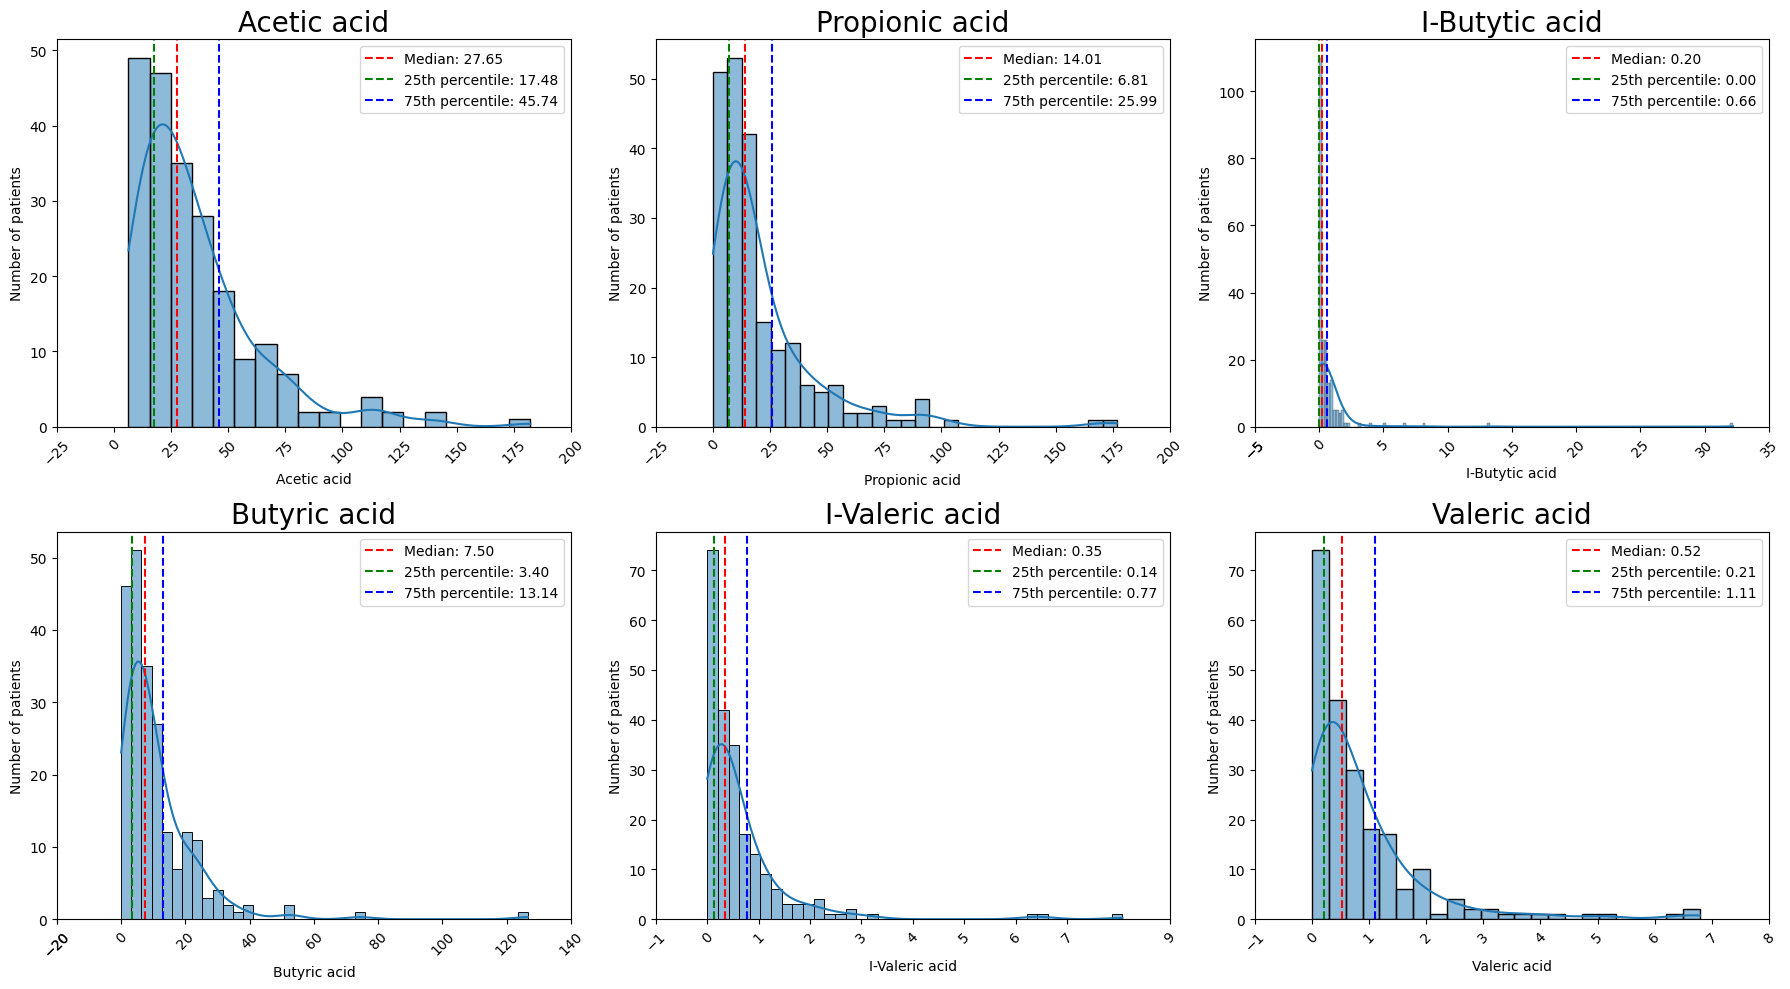

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_distributions(dataframe, features, cols=3):
    # Number of features determines the number of rows and columns in the grid
    nrows = int(np.ceil(len(features) / cols))

    # Create a figure with subplots in a grid defined by nrows and cols
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(cols * 6, nrows * 5))

    # Flatten axes array for easy iteration in case of one row or column
    axes = axes.flatten()

    # Loop through the features and create an area plot for each one
    for i, feature in enumerate(features):
        # Plot the histogram with KDE
        sns.histplot(dataframe[feature], kde=True, ax=axes[i])
        axes[i].set_title(feature, size=20)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Number of patients')

        # Calculate the median and percentiles
        median = dataframe[feature].median()
        q25 = dataframe[feature].quantile(0.25)
        q75 = dataframe[feature].quantile(0.75)

        # Draw vertical lines for the median and percentiles
        axes[i].axvline(median, color='r', linestyle='--', label=f'Median: {median:.2f}')
        axes[i].axvline(q25, color='g', linestyle='--', label=f'25th percentile: {q25:.2f}')
        axes[i].axvline(q75, color='b', linestyle='--', label=f'75th percentile: {q75:.2f}')
        axes[i].legend(loc='upper right')

        # Check the number of unique values
        unique_values = dataframe[feature].nunique()
        unique_value_threshold = 10  # Define a threshold for the number of unique values

        # Rotate x-axis labels for better readability if necessary
        if unique_values > unique_value_threshold:
            axes[i].tick_params(axis='x', rotation=45)
            max_xticks = unique_value_threshold
            x_ticks = axes[i].get_xticks()
            reduced_ticks = np.linspace(0, len(x_ticks) - 1, max_xticks, dtype=int)
            axes[i].set_xticks([x_ticks[j] for j in reduced_ticks])

    # If there are more subplots than features, turn off the extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # # Create legend with custom entries
    # handles, labels = axes[i].get_legend_handles_labels()
    # plt.legend(handles=handles, labels=labels, loc='upper right')

    plt.tight_layout()
    plt.show()
selected_features = SCFA

############################################################
plot_feature_distributions(data['metadata_A'], selected_features)

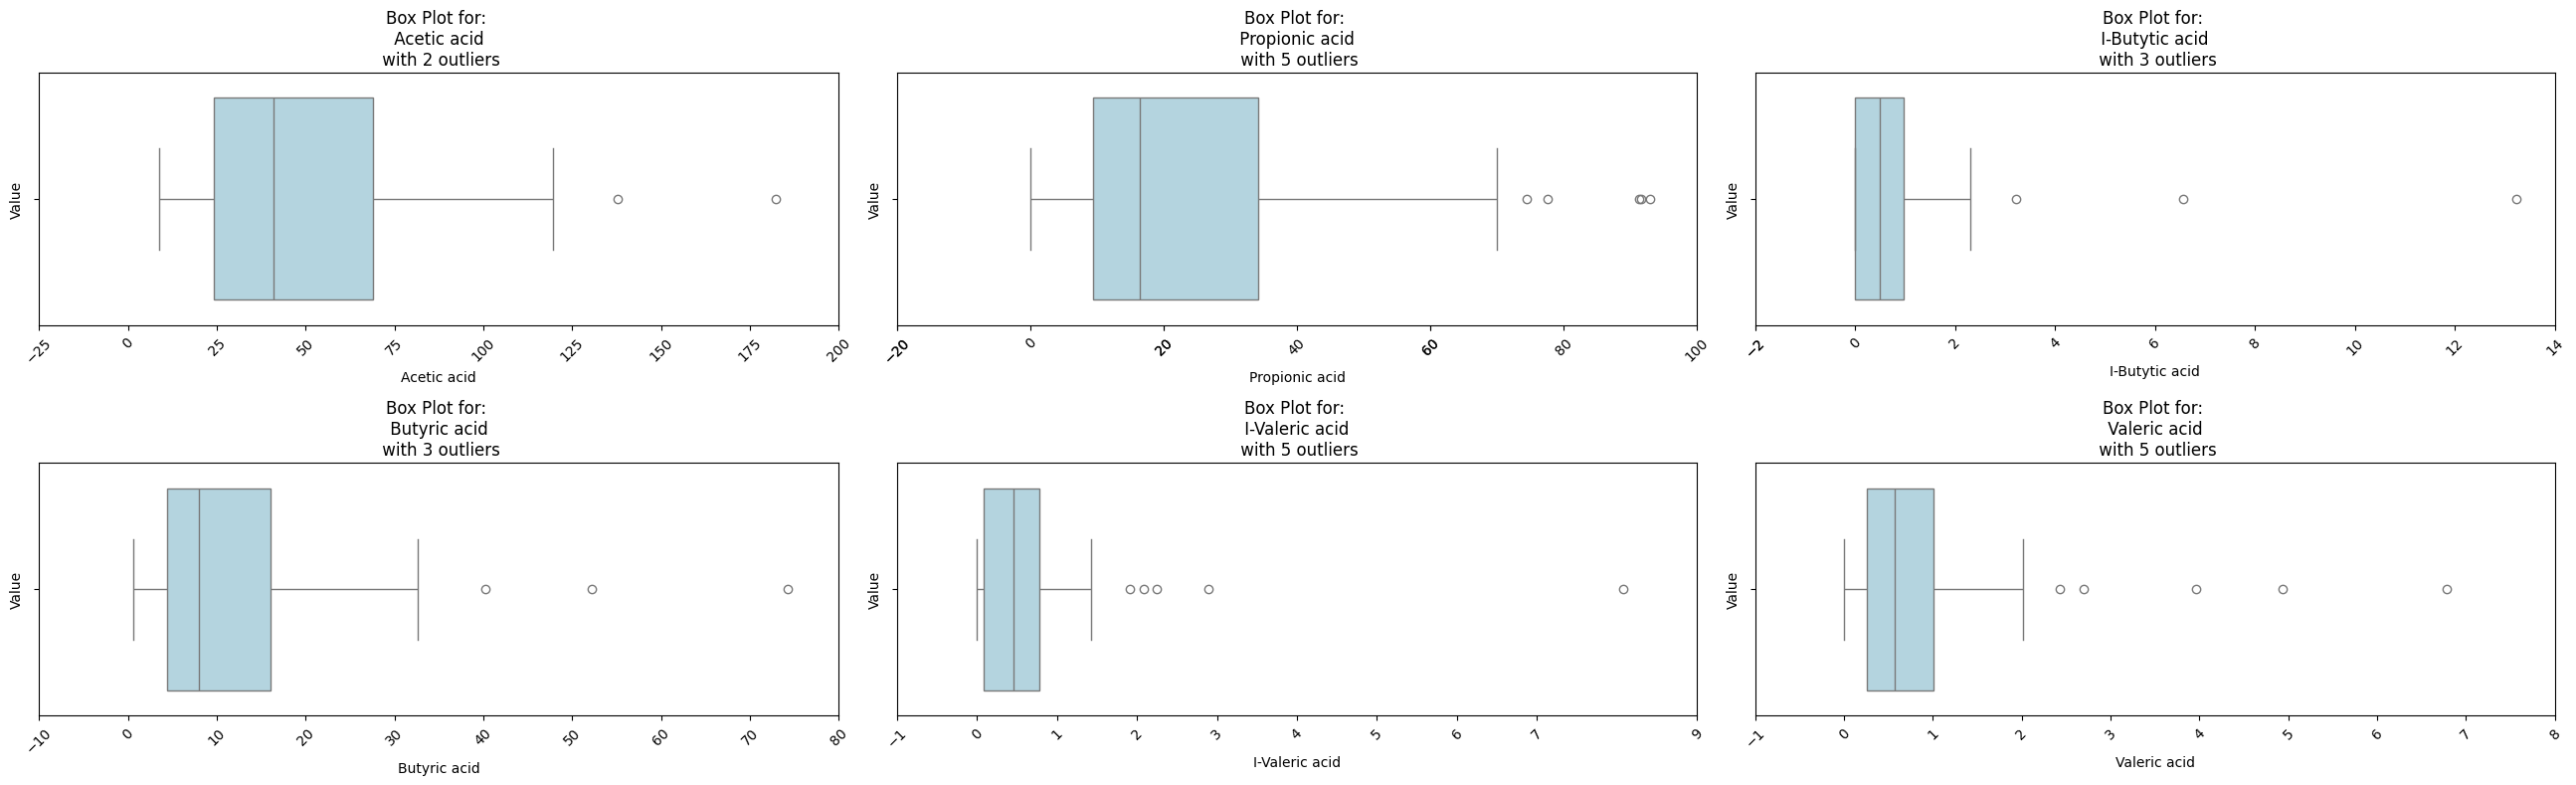

In [ ]:
# Function to detect outliers using IQR
def find_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Defining columns
columns =  SCFA
df_metadata = data['metadata_A']

# Number of columns in each row
num_cols_per_row = 3

# Calculate the number of rows needed
num_rows = len(columns) // num_cols_per_row
num_rows += len(columns) % num_cols_per_row

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(26, 4*num_rows))

# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()

# Threshold for reducing x-ticks
unique_value_threshold = 10

# Iterate through numerical columns and create box plots
df_metadata_control = df_metadata[df_metadata["Tag"] == 0]
df_metadata_case = df_metadata[df_metadata["Tag"] == 1]
for i, column in enumerate(columns):
    outliers_count = len(find_outliers(pd.to_numeric(df_metadata[column], errors='coerce')))

    sns.boxplot(x=df_metadata[column], color='lightblue', ax=axes[i])
    axes[i].set_title(f'Box Plot for: \n {column} \n with {outliers_count} outliers')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Value')

    # Check the number of unique values
    unique_values = df_metadata[column].nunique()
    # Rotate x-axis labels for better readability if necessary
    if unique_values > unique_value_threshold:
        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=45)
        # Reduce the number of x-ticks
        max_xticks = unique_value_threshold
        x_ticks = axes[i].get_xticks()
        reduced_ticks = np.linspace(0, len(x_ticks) - 1, max_xticks, dtype=int)
        axes[i].set_xticks([x_ticks[j] for j in reduced_ticks])

# If there are more subplots than features, turn off the extra subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

# **Microbiome- Distribution plots (senity checks)**

##**Checking pre-process characteristics:**

1. For each microbe- how many samples are not 0

(159, 178)


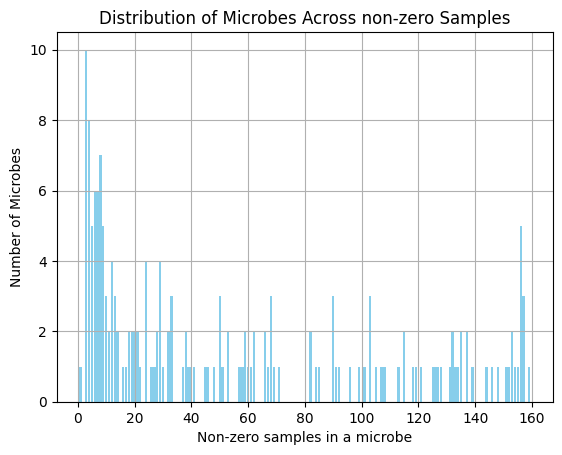

Features with non-zero counts lower than the threshold:
Feature 2: 0.0
Feature 45: 0.0052824994975857
Feature 51: 0.0
Feature 56: 0.0
Feature 67: 0.0
Feature 76: 0.0
Feature 106: 0.0
Feature 107: 0.0
Feature 133: 0.0
Feature 153: 0.0
Feature 163: 0.0


In [ ]:
# Define parameters
non_zero_treshold = 4

print(df_MIPMLP_mean.shape)

# Ensure the DataFrame columns are numeric
last_row = df_MIPMLP_mean.iloc[-1:]
df_MIPMLP_mean = df_MIPMLP_mean.iloc[:-1].apply(pd.to_numeric, errors='coerce')
df_MIPMLP_mean = pd.concat([df_MIPMLP_mean, last_row], ignore_index=False)

# Count the number of non-zero entries for each column
non_zero_counts_per_col = (df_MIPMLP_mean != 0).sum(axis=0)
microbe_names = df_MIPMLP_mean.iloc[-1]
microbe_names_list = microbe_names.values.tolist()

# Extract feature with low count of samples: indices and corresponding feature names
low_count_col_indices = [i for i, count in enumerate(non_zero_counts_per_col) if count < non_zero_treshold]
low_count_features = [microbe_names_list[i] for i in low_count_col_indices]

samples_counts = {}
for count in non_zero_counts_per_col:
    samples_counts.setdefault(count, 0)
    samples_counts[count] += 1

# Plot histogram
plt.bar(samples_counts.keys(), samples_counts.values(), color='skyblue')
plt.xlabel('Non-zero samples in a microbe')
plt.ylabel('Number of Microbes')
plt.title('Distribution of Microbes Across non-zero Samples')
plt.grid(True)
plt.show()

# Print feature names and corresponding indices lower than the threshold
print("Features with non-zero counts lower than the threshold:")
for feature, index in zip(low_count_features, low_count_col_indices):
    print(f"Feature {index}: {feature}")

# # DataFrame of the results
# feature_counts_df = pd.DataFrame({'Feature': microbe_names_list, 'Non-zero Count': non_zero_counts_per_col})
# print(feature_counts_df)

2. For each sample- how much features are not 0

[147]


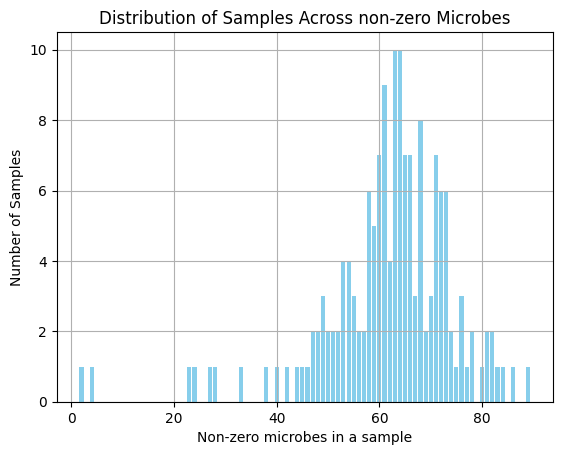

Samples with non-zero counts lower than the threshold:
Sample 147


In [ ]:
# Define parameters
non_zero_treshold = 4

# Count the number of non-zero features for each sample (row)
non_zero_count_per_row = (df_MIPMLP_mean.iloc[:, :-1] != 0).sum(axis=1)

# Extract feature with low count of samples: indices and corresponding feature names
low_count_row_indices = [i for i, count in enumerate(non_zero_count_per_row) if count < non_zero_treshold]
print(low_count_row_indices)

features_counts = {}
for count in non_zero_count_per_row:
    features_counts.setdefault(count, 0)
    features_counts[count] += 1

# Plot histogram
plt.bar(features_counts.keys(), features_counts.values(), color='skyblue')
plt.xlabel('Non-zero microbes in a sample')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples Across non-zero Microbes')
plt.grid(True)
plt.show()

# Print samples lower than the threshold
print("Samples with non-zero counts lower than the threshold:")
for sample_index in low_count_row_indices:
    print(f"Sample {sample_index}")

## **Checkimg MIPMLP characterisics**

In [ ]:
# Define parameters
threshold = 4
filtered_col_indices = []
filtered_col_names = []

# Iterate through each column
for idx, column in enumerate(df_MIPMLP_mean.columns):
    # Get the most frequent value and its count
    most_frequent_value = df_MIPMLP_mean[column].mode()[0]
    most_frequent_count = (df_MIPMLP_mean[column] == most_frequent_value).sum()
    # Calculate the number of unique values excluding the most frequent one
    unique_values = df_MIPMLP_mean[column].nunique() - 1
    # Check if the unique values count is below the threshold
    if unique_values < threshold:
        filtered_col_indices.append(idx)
        filtered_col_names.append(column)

# Print the results
print("Columns with unique values below the threshold (excluding the most frequent value):")
print("Indices:", filtered_col_indices)
print("Names:", filtered_col_names)
print(len(filtered_col_indices))

Columns with unique values below the threshold (excluding the most frequent value):
Indices: [2, 45, 51, 56, 67, 76, 106, 107, 133, 153, 163]
Names: ['k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__[Methanomassiliicoccaceae];g__;s__', 'k__Bacteria;p__Elusimicrobia;c__Elusimicrobia;o__Elusimicrobiales;f__Elusimicrobiaceae;g__;s__', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__mucosae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus;s__garvieae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__perfringens', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio;s__crossotus', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__Peptostreptococcus;s__anaerobius', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__[Clostridium];s__', 'k_

# **Microbiome Diversity**


ALPHA DIVERSITY ANALYSIS (Shannon Index)

Alpha Diversity Statistics:
  Group A: Mean=2.652, SD=0.441, n=29
  Group B: Mean=2.294, SD=0.493, n=12
  Group C: Mean=2.483, SD=0.633, n=14

Mann-Whitney U Tests:
  A vs BC: U=486.00, p=0.0674
  B vs C: U=63.00, p=0.2917

✓ Alpha diversity plot saved as 'alpha_diversity_boxplot.png'


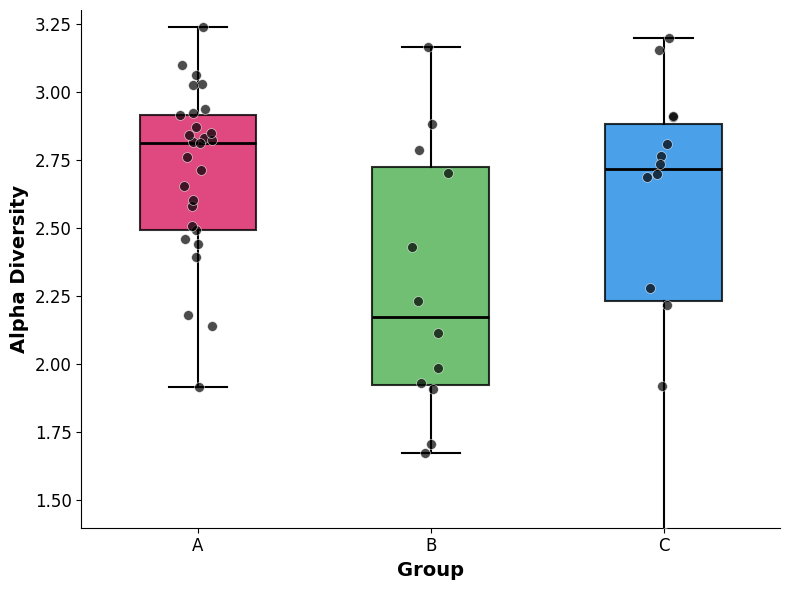

In [ ]:
# ============================================================================
# ALPHA DIVERSITY ANALYSIS
# ============================================================================

def analyze_alpha_diversity(microbiome_df, metadata_df):
    """
    Calculate and compare alpha diversity (Shannon index) between groups.

    Parameters:
    -----------
    microbiome_df : pd.DataFrame
        Microbiome abundance data (samples x taxa)
    metadata_df : pd.DataFrame
        Metadata with group labels

    Returns:
    --------
    pd.DataFrame: Alpha diversity values with group labels
    """
    print("\n" + "=" * 60)
    print("ALPHA DIVERSITY ANALYSIS (Shannon Index)")
    print("=" * 60)

    # Calculate Shannon diversity
    shannon = alpha_diversity('shannon', microbiome_df.values, microbiome_df.index)

    # Create results dataframe
    alpha_df = pd.DataFrame({
        'Shannon_Diversity': shannon,
        'Sample_ID': microbiome_df.index
    })

    # Merge with metadata to get group labels
    alpha_df = alpha_df.merge(
        metadata_df[[Config.TARGET_COLUMN]],
        left_on='Sample_ID',
        right_index=True,
        how='left'
    )

    # Statistical comparisons
    print("\nAlpha Diversity Statistics:")
    for group in ['A', 'B', 'C']:
        group_data = alpha_df[alpha_df[Config.TARGET_COLUMN] == group]['Shannon_Diversity']
        print(f"  Group {group}: Mean={group_data.mean():.3f}, "
              f"SD={group_data.std():.3f}, n={len(group_data)}")

    # Mann-Whitney tests
    print("\nMann-Whitney U Tests:")

    # A vs BC
    group_A = alpha_df[alpha_df[Config.TARGET_COLUMN] == 'A']['Shannon_Diversity']
    group_BC = alpha_df[alpha_df[Config.TARGET_COLUMN].isin(['B', 'C'])]['Shannon_Diversity']
    stat, pval = mannwhitneyu(group_A, group_BC, alternative='two-sided')
    print(f"  A vs BC: U={stat:.2f}, p={pval:.4f}")

    # B vs C
    group_B = alpha_df[alpha_df[Config.TARGET_COLUMN] == 'B']['Shannon_Diversity']
    group_C = alpha_df[alpha_df[Config.TARGET_COLUMN] == 'C']['Shannon_Diversity']
    stat, pval = mannwhitneyu(group_B, group_C, alternative='two-sided')
    print(f"  B vs C: U={stat:.2f}, p={pval:.4f}")

    # Plot alpha diversity
    plot_alpha_diversity(alpha_df)

    return alpha_df


def plot_alpha_diversity(alpha_df):
    """
    Create boxplot of alpha diversity by group (matching Panel B).

    Parameters:
    -----------
    alpha_df : pd.DataFrame
        DataFrame with Shannon diversity and group labels
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    # Define colors matching the paper figure
    colors = {'A': '#D81B60', 'B': '#4CAF50', 'C': '#1E88E5'}

    # Prepare data for each group
    data_by_group = [
        alpha_df[alpha_df[Config.TARGET_COLUMN] == g]['Shannon_Diversity'].values
        for g in ['A', 'B', 'C']
    ]

    # Create boxplot
    bp = ax.boxplot(
        data_by_group,
        labels=['A', 'B', 'C'],
        patch_artist=True,
        widths=0.5,
        showfliers=False  # We'll plot points separately
    )

    # Color boxes
    for patch, group in zip(bp['boxes'], ['A', 'B', 'C']):
        patch.set_facecolor(colors[group])
        patch.set_alpha(0.8)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)

    # Style whiskers, caps, and medians
    for whisker in bp['whiskers']:
        whisker.set_color('black')
        whisker.set_linewidth(1.5)

    for cap in bp['caps']:
        cap.set_color('black')
        cap.set_linewidth(1.5)

    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(2)

    # Add individual points (jittered)
    np.random.seed(42)
    for i, group in enumerate(['A', 'B', 'C']):
        group_data = alpha_df[alpha_df[Config.TARGET_COLUMN] == group]['Shannon_Diversity'].values
        x_pos = i + 1
        # Add jitter to x positions
        x_jittered = x_pos + np.random.normal(0, 0.04, size=len(group_data))
        ax.scatter(x_jittered, group_data,
                  color='black', s=50, alpha=0.7, zorder=3, edgecolors='white', linewidths=0.5)

    ax.set_xlabel('Group', fontsize=14, fontweight='bold')
    ax.set_ylabel('Alpha Diversity', fontsize=14, fontweight='bold')
    ax.set_ylim(1.4, 3.3)

    # Clean up the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig('alpha_diversity_boxplot.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Alpha diversity plot saved as 'alpha_diversity_boxplot.png'")
    plt.show()
    #plt.close()



# ========== Alpha Diversity ==========
alpha_results = analyze_alpha_diversity(data['microbiome_mean'], data['metadata_mean'])



BETA DIVERSITY ANALYSIS - ALL GROUPS (Bray-Curtis)
Analyzing 55 samples across groups A, B, and C
Calculating Bray-Curtis distance matrix...
Performing Principal Coordinates Analysis (PCoA)...

COMPARISON 1: A (Non-smokers) vs BC (Smokers)

Performing PERMANOVA test (A vs BC)...

PERMANOVA Results (A vs BC):
  Test statistic: 3.2243
  p-value: 0.0040
  Number of permutations: 999

Testing for homogeneity of dispersion (PERMDISP - A vs BC)...

PERMDISP Results (A vs BC):
  Test statistic: 1.6910
  p-value: 0.2010
  Number of permutations: 999
  ✓ No significant difference in dispersion (p ≥ 0.05)
     PERMANOVA results reflect true compositional differences.

COMPARISON 2: B (Did not quit) vs C (Quit)
Analyzing 26 samples (B: 12, C: 14)

Performing PERMANOVA test (B vs C)...

PERMANOVA Results (B vs C):
  Test statistic: 1.0219
  p-value: 0.3530
  Number of permutations: 999

Testing for homogeneity of dispersion (PERMDISP - B vs C)...

PERMDISP Results (B vs C):
  Test statistic: 2.85

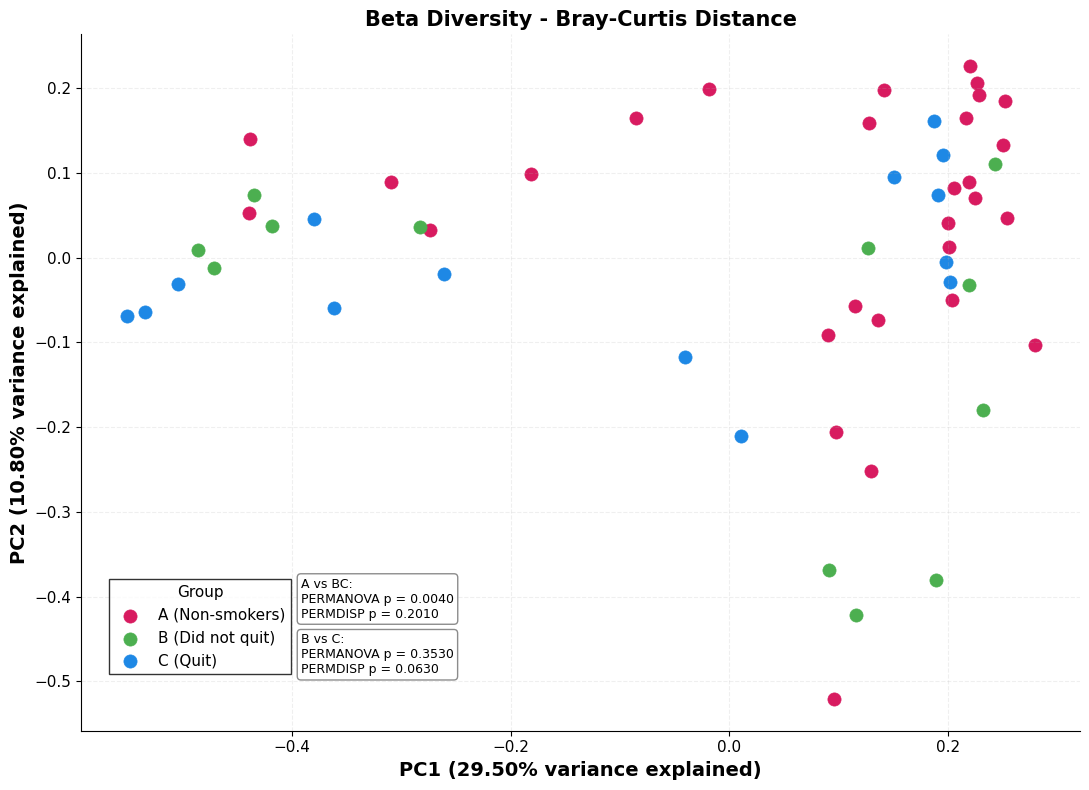

In [ ]:
# ============================================================================
# BETA DIVERSITY ANALYSIS
# ============================================================================

def analyze_beta_diversity_combined(microbiome_df, metadata_df):
    """
    Calculate beta diversity (Bray-Curtis distance) for all three groups combined.
    Perform PERMANOVA and PERMDISP for three comparisons: A vs BC, B vs C, and A vs B vs C.

    Parameters:
    -----------
    microbiome_df : pd.DataFrame
        Microbiome abundance data
    metadata_df : pd.DataFrame
        Metadata with group labels

    Returns:
    --------
    dict: Results containing distance matrices, PCoA, and statistical tests
    """
    print(f"\n{'=' * 60}")
    print(f"BETA DIVERSITY ANALYSIS - ALL GROUPS (Bray-Curtis)")
    print(f"{'=' * 60}")

    print(f"Analyzing {len(microbiome_df)} samples across groups A, B, and C")

    # Calculate Bray-Curtis distance for all samples
    print("Calculating Bray-Curtis distance matrix...")
    distance_matrix_all = beta_diversity(
        'braycurtis',
        microbiome_df.values,
        microbiome_df.index
    )

    # Perform PCoA on all samples
    print("Performing Principal Coordinates Analysis (PCoA)...")
    pcoa_results = pcoa(distance_matrix_all)

    # ========== Comparison 1: A vs BC ==========
    print(f"\n{'=' * 60}")
    print("COMPARISON 1: A (Non-smokers) vs BC (Smokers)")
    print(f"{'=' * 60}")

    # Filter samples for A vs BC comparison
    samples_a_bc = metadata_df.index
    microbiome_a_bc = microbiome_df.loc[samples_a_bc]
    metadata_a_bc = metadata_df.loc[samples_a_bc]

    # Create binary grouping (A vs BC)
    groups_a_bc = metadata_a_bc[Config.TARGET_COLUMN].replace(
        {'A': 'A', 'B': 'BC', 'C': 'BC'}
    )

    # Calculate distance matrix for A vs BC
    distance_matrix_a_bc = beta_diversity(
        'braycurtis',
        microbiome_a_bc.values,
        microbiome_a_bc.index
    )

    # PERMANOVA for A vs BC
    print("\nPerforming PERMANOVA test (A vs BC)...")
    permanova_a_bc = permanova(
        distance_matrix_a_bc,
        groups_a_bc,
        permutations=999
    )

    print(f"\nPERMANOVA Results (A vs BC):")
    print(f"  Test statistic: {permanova_a_bc['test statistic']:.4f}")
    print(f"  p-value: {permanova_a_bc['p-value']:.4f}")
    print(f"  Number of permutations: {permanova_a_bc['number of permutations']}")

    # PERMDISP for A vs BC
    print("\nTesting for homogeneity of dispersion (PERMDISP - A vs BC)...")
    permdisp_a_bc = test_beta_dispersion(distance_matrix_a_bc, groups_a_bc)

    print(f"\nPERMDISP Results (A vs BC):")
    print(f"  Test statistic: {permdisp_a_bc['test statistic']:.4f}")
    print(f"  p-value: {permdisp_a_bc['p-value']:.4f}")
    print(f"  Number of permutations: {permdisp_a_bc['number of permutations']}")

    if permdisp_a_bc['p-value'] < 0.05:
        print(f"  ⚠ Significant difference in dispersion (p < 0.05)")
        print(f"     PERMANOVA results may be confounded by dispersion differences.")
    else:
        print(f"  ✓ No significant difference in dispersion (p ≥ 0.05)")
        print(f"     PERMANOVA results reflect true compositional differences.")

    # ========== Comparison 2: B vs C ==========
    print(f"\n{'=' * 60}")
    print("COMPARISON 2: B (Did not quit) vs C (Quit)")
    print(f"{'=' * 60}")

    # Filter samples for B vs C comparison
    samples_b_c = metadata_df[
        metadata_df[Config.TARGET_COLUMN].isin(['B', 'C'])
    ].index
    microbiome_b_c = microbiome_df.loc[samples_b_c]
    metadata_b_c = metadata_df.loc[samples_b_c]

    groups_b_c = metadata_b_c[Config.TARGET_COLUMN]

    print(f"Analyzing {len(microbiome_b_c)} samples (B: {(groups_b_c=='B').sum()}, C: {(groups_b_c=='C').sum()})")

    # Calculate distance matrix for B vs C
    distance_matrix_b_c = beta_diversity(
        'braycurtis',
        microbiome_b_c.values,
        microbiome_b_c.index
    )

    # PERMANOVA for B vs C
    print("\nPerforming PERMANOVA test (B vs C)...")
    permanova_b_c = permanova(
        distance_matrix_b_c,
        groups_b_c,
        permutations=999
    )

    print(f"\nPERMANOVA Results (B vs C):")
    print(f"  Test statistic: {permanova_b_c['test statistic']:.4f}")
    print(f"  p-value: {permanova_b_c['p-value']:.4f}")
    print(f"  Number of permutations: {permanova_b_c['number of permutations']}")

    # PERMDISP for B vs C
    print("\nTesting for homogeneity of dispersion (PERMDISP - B vs C)...")
    permdisp_b_c = test_beta_dispersion(distance_matrix_b_c, groups_b_c)

    print(f"\nPERMDISP Results (B vs C):")
    print(f"  Test statistic: {permdisp_b_c['test statistic']:.4f}")
    print(f"  p-value: {permdisp_b_c['p-value']:.4f}")
    print(f"  Number of permutations: {permdisp_b_c['number of permutations']}")

    if permdisp_b_c['p-value'] < 0.05:
        print(f"  ⚠ Significant difference in dispersion (p < 0.05)")
        print(f"     PERMANOVA results may be confounded by dispersion differences.")
    else:
        print(f"  ✓ No significant difference in dispersion (p ≥ 0.05)")
        print(f"     PERMANOVA results reflect true compositional differences.")

    # ========== Comparison 3: A vs B vs C (All three groups) ==========
    print(f"\n{'=' * 60}")
    print("COMPARISON 3: A vs B vs C (All three groups)")
    print(f"{'=' * 60}")

    # Use all samples with original grouping
    groups_abc = metadata_df[Config.TARGET_COLUMN]

    print(f"Analyzing {len(microbiome_df)} samples (A: {(groups_abc=='A').sum()}, "
          f"B: {(groups_abc=='B').sum()}, C: {(groups_abc=='C').sum()})")

    # PERMANOVA for A vs B vs C (using already calculated distance_matrix_all)
    print("\nPerforming PERMANOVA test (A vs B vs C)...")
    permanova_abc = permanova(
        distance_matrix_all,
        groups_abc,
        permutations=999
    )

    print(f"\nPERMANOVA Results (A vs B vs C):")
    print(f"  Test statistic: {permanova_abc['test statistic']:.4f}")
    print(f"  p-value: {permanova_abc['p-value']:.4f}")
    print(f"  Number of permutations: {permanova_abc['number of permutations']}")

    # PERMDISP for A vs B vs C
    print("\nTesting for homogeneity of dispersion (PERMDISP - A vs B vs C)...")
    permdisp_abc = test_beta_dispersion(distance_matrix_all, groups_abc)

    print(f"\nPERMDISP Results (A vs B vs C):")
    print(f"  Test statistic: {permdisp_abc['test statistic']:.4f}")
    print(f"  p-value: {permdisp_abc['p-value']:.4f}")
    print(f"  Number of permutations: {permdisp_abc['number of permutations']}")

    if permdisp_abc['p-value'] < 0.05:
        print(f"  ⚠ Significant difference in dispersion (p < 0.05)")
        print(f"     PERMANOVA results may be confounded by dispersion differences.")
    else:
        print(f"  ✓ No significant difference in dispersion (p ≥ 0.05)")
        print(f"     PERMANOVA results reflect true compositional differences.")

    # Plot combined PCoA with all three sets of statistics
    plot_pcoa_combined(pcoa_results, metadata_df,
                       permanova_a_bc, permdisp_a_bc,
                       permanova_b_c, permdisp_b_c,
                       permanova_abc, permdisp_abc)

    # Return all results
    results = {
        'distance_matrix_all': distance_matrix_all,
        'pcoa_results': pcoa_results,
        'A_vs_BC': {
            'distance_matrix': distance_matrix_a_bc,
            'permanova': permanova_a_bc,
            'permdisp': permdisp_a_bc
        },
        'B_vs_C': {
            'distance_matrix': distance_matrix_b_c,
            'permanova': permanova_b_c,
            'permdisp': permdisp_b_c
        },
        'A_vs_B_vs_C': {
            'distance_matrix': distance_matrix_all,
            'permanova': permanova_abc,
            'permdisp': permdisp_abc
        }
    }

    return results


def test_beta_dispersion(distance_matrix, groups, permutations=999):
    """
    Test for homogeneity of multivariate dispersions (PERMDISP).

    Parameters:
    -----------
    distance_matrix : skbio.DistanceMatrix
        Distance matrix
    groups : pd.Series
        Group labels
    permutations : int
        Number of permutations

    Returns:
    --------
    dict: Results containing test statistic and p-value
    """
    from skbio.stats.distance import permdisp

    result = permdisp(distance_matrix, groups, permutations=permutations)

    return {
        'test statistic': result['test statistic'],
        'p-value': result['p-value'],
        'number of permutations': permutations
    }


def plot_pcoa_combined(pcoa_results, metadata,
                       permanova_a_bc, permdisp_a_bc,
                       permanova_b_c, permdisp_b_c,
                       permanova_abc, permdisp_abc):
    """
    Create PCoA plot with all three groups (A, B, C) colored separately.
    Display statistics for all three comparisons.

    Parameters:
    -----------
    pcoa_results : skbio.OrdinationResults
        PCoA results from skbio
    metadata : pd.DataFrame
        Metadata with group labels
    permanova_a_bc : dict
        PERMANOVA results for A vs BC
    permdisp_a_bc : dict
        PERMDISP results for A vs BC
    permanova_b_c : dict
        PERMANOVA results for B vs C
    permdisp_b_c : dict
        PERMDISP results for B vs C
    permanova_abc : dict
        PERMANOVA results for A vs B vs C
    permdisp_abc : dict
        PERMDISP results for A vs B vs C
    """
    fig, ax = plt.subplots(figsize=(11, 8))

    # Extract PC1 and PC2
    pc1 = pcoa_results.samples['PC1'].values
    pc2 = pcoa_results.samples['PC2'].values

    # Get proportion explained
    prop_explained = pcoa_results.proportion_explained
    pc1_var = prop_explained[0] * 100
    pc2_var = prop_explained[1] * 100

    # Define colors for each group
    color_map = {
        'A': '#D81B60',  # Pink/Magenta (Non-smokers)
        'B': '#4CAF50',  # Green (Did not quit)
        'C': '#1E88E5'   # Blue (Quit smoking)
    }

    label_map = {
        'A': 'A (Non-smokers)',
        'B': 'B (Did not quit)',
        'C': 'C (Quit)'
    }

    # Plot points by group
    for group in ['A', 'B', 'C']:
        mask = metadata[Config.TARGET_COLUMN] == group
        if mask.sum() > 0:
            ax.scatter(
                pc1[mask], pc2[mask],
                c=color_map[group],
                label=label_map[group],
                s=90,
                # alpha=0.7,
                # edgecolors='black',
                linewidths=0.5
            )

    # Add statistical results as text - three separate boxes
    stats_text_1 = (f"A vs BC:\n"
                    f"PERMANOVA p = {permanova_a_bc['p-value']:.4f}\n"
                    f"PERMDISP p = {permdisp_a_bc['p-value']:.4f}")

    stats_text_2 = (f"B vs C:\n"
                    f"PERMANOVA p = {permanova_b_c['p-value']:.4f}\n"
                    f"PERMDISP p = {permdisp_b_c['p-value']:.4f}")

    stats_text_3 = (f"A vs B vs C:\n"
                    f"PERMANOVA p = {permanova_abc['p-value']:.4f}\n"
                    f"PERMDISP p = {permdisp_abc['p-value']:.4f}")

    # # Top left for A vs BC
    ax.text(0.22, 0.22, stats_text_1,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

    # Below first box for B vs C
    ax.text(0.22, 0.14, stats_text_2,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

    # # Below second box for A vs B vs C
    # ax.text(0.02, 0.62, stats_text_3,
    #         transform=ax.transAxes,
    #         fontsize=9,
    #         verticalalignment='top',
    #         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

    ax.set_xlabel(f'PC1 ({pc1_var:.2f}% variance explained)',
                  fontsize=14, fontweight='bold')
    ax.set_ylabel(f'PC2 ({pc2_var:.2f}% variance explained)',
                  fontsize=14, fontweight='bold')
    ax.set_title('Beta Diversity - Bray-Curtis Distance',
                 fontsize=15, fontweight='bold')

    # Add legend
    ax.legend(title='Group', fontsize=11, title_fontsize=11,
             loc='lower left',  bbox_to_anchor=(0.02, 0.07), frameon=True, fancybox=False,
             edgecolor='black')

    # Clean up plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=11)
    ax.grid(True, alpha=0.2, linestyle='--')

    plt.tight_layout()
    plt.savefig('pcoa_combined_braycurtis.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Combined PCoA plot saved as 'pcoa_combined_braycurtis.png'")
    plt.show()


# ============================================================================
# Beta Diversity
# ============================================================================

# ========== Beta Diversity (All three comparisons) ==========
results = analyze_beta_diversity_combined(
    data['microbiome_mean'],
    data['metadata_mean']
)

# Access results if needed:
# results['A_vs_BC']['permanova']
# results['A_vs_BC']['permdisp']
# results['B_vs_C']['permanova']
# results['B_vs_C']['permdisp']
# results['A_vs_B_vs_C']['permanova']
# results['A_vs_B_vs_C']['permdisp']